# Medical School issues Medical Qualification to Doctor

## Before running through this notebook you have configured the agent in [Part 2.1 - Initialising the Medical School Agent.ipynb](http://127.0.0.1:8889/notebooks/Part%202.1%20-%20Initialising%20the%20Medical%20School%20Agent.ipynb).



## 1. Initialise a controller for Medical School

In [27]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://medical-school-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [28]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<AriesAgentController.listen_webhooks() done, defined at /aries_basic_controller/aries_controller.py:77> exception=OSError(98, "error while attempting to bind on address ('0.0.0.0', 8022): address already in use")>
Traceback (most recent call last):
  File "/aries_basic_controller/aries_controller.py", line 83, in listen_webhooks
    await self.webhook_site.start()
  File "/opt/conda/lib/python3.7/site-packages/aiohttp/web_runner.py", line 104, in start
    reuse_port=self._reuse_port)
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1385, in create_server
    % (sa, err.strerror.lower())) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8022): address already in use


## 3. Copy across the `schema_id` and `cred_def_id` stored in Part 2.1

The Medical School Agent must have a credential definition on the ledger to issue these credentials.


In [29]:
%store -r cred_def_id
%store -r schema_id
print(cred_def_id)
print(schema_id)

TQ6ca5s3tGaKRK6DNHoh3D:3:CL:141255:default
2yWoMSfeTtYBFpUJFcnpqL:2:Medical Qual:0.0.1


## 4. Make sure you have a Mobile SSI Wallet dowloaded and configured to using the Sovrin StagingNet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 5. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 5a. Check for any existing connections

In [30]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: 7378dc4e-52fa-4675-adc3-fc3491f84e16 Status: active
ConnectionID: fb8dcb36-6590-4eb6-89dd-7555658b754a Status: invitation


## 5b. Create an Invitation

In [31]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID ef74570d-bb5f-4505-8142-677763f5fc81
Invitation
https://e34c7fe6cfb2.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiYTkyMjRhYTUtNzkxZi00ZmYxLTg1ODUtOWI1ZjU4ZGY2NmJhIiwgInJlY2lwaWVudEtleXMiOiBbIkNLZXFzNXdGSG1DdFlnQmJ0WEtSZEdYUE1xeGtraGc0R1NrSlZ0aXRoQmRwIl0sICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly9lMzRjN2ZlNmNmYjIubmdyb2suaW8iLCAibGFiZWwiOiAiTWVkaWNhbCBTY2hvb2wifQ==


## 5c. Generate QR Code to be scanned with Mobile SSI Wallet

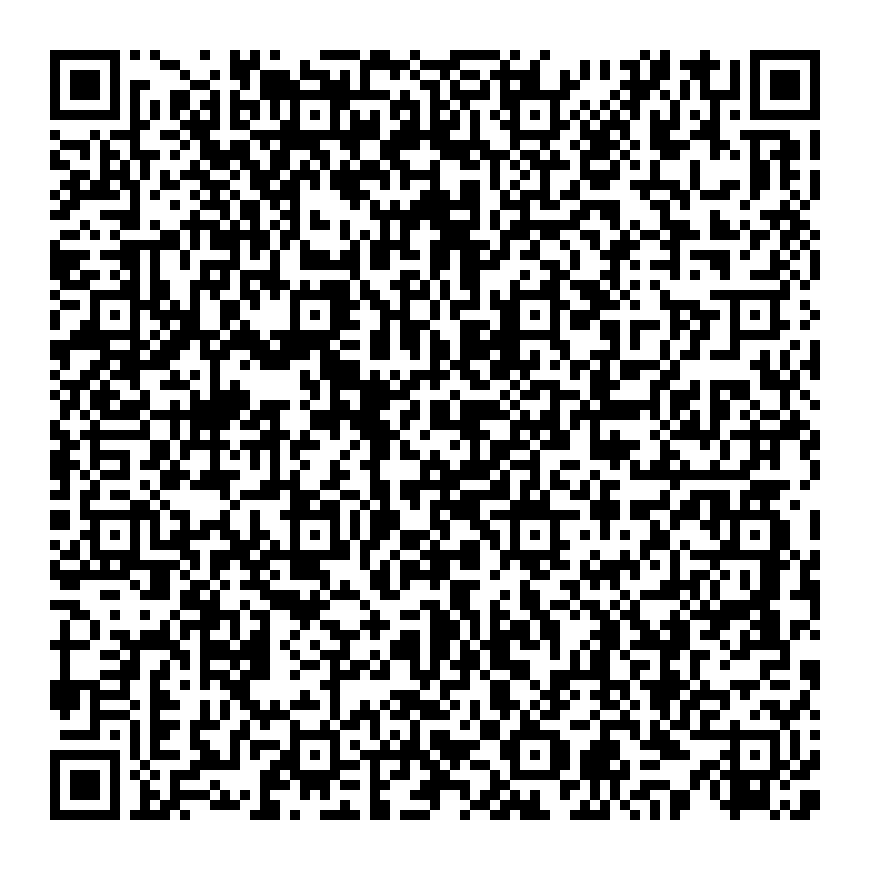

Connection message {'initiator': 'self', 'connection_id': '7378dc4e-52fa-4675-adc3-fc3491f84e16', 'created_at': '2020-09-22 13:03:37.195642Z', 'their_did': '7yB92kA9mTiewUUmpNzeGu', 'invitation_key': '9NU6Zhp7HX9RsqjkJvZ8iVjPPhcy6tGPDEALJXhXyi81', 'state': 'request', 'invitation_mode': 'once', 'updated_at': '2020-09-22 13:03:53.883133Z', 'their_label': "Vineeth's Pixel 3", 'accept': 'auto', 'routing_state': 'none'} 7378dc4e-52fa-4675-adc3-fc3491f84e16
Connection message {'initiator': 'self', 'connection_id': '7378dc4e-52fa-4675-adc3-fc3491f84e16', 'created_at': '2020-09-22 13:03:37.195642Z', 'their_did': '7yB92kA9mTiewUUmpNzeGu', 'invitation_key': '9NU6Zhp7HX9RsqjkJvZ8iVjPPhcy6tGPDEALJXhXyi81', 'state': 'response', 'invitation_mode': 'once', 'my_did': 'AhP2NPD9DX7rY5TqzBcBcP', 'updated_at': '2020-09-22 13:03:54.079533Z', 'their_label': "Vineeth's Pixel 3", 'accept': 'auto', 'routing_state': 'none'} 7378dc4e-52fa-4675-adc3-fc3491f84e16


In [6]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('medical-school-agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./medical-school-agent_invite_QRcode.png')

## 5d. Check if established connection is in active state

In [32]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId ef74570d-bb5f-4505-8142-677763f5fc81 is active
ConnectionId: ef74570d-bb5f-4505-8142-677763f5fc81 is now active. Continue with notebook


###  6a.Generate Proof Request


In [33]:
print("Request proof of Passport information")

#Set some variables

REVOCATION = False
SELF_ATTESTED = False
EXCHANGE_TRACING = False

req_attrs = [
    {"name": "PSS Given Names", "restrictions": []},
    {"name": "PSS Surname", "restrictions": []},
]

if REVOCATION:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = []

indy_proof_request = {
    "name": "Proof of Passport Credential",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if REVOCATION:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = EXCHANGE_TRACING
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": EXCHANGE_TRACING,
}

Request proof of Passport information


### 6b. Send Proof Request

In [34]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)

ClientResponseError: 403, message='Connection ef74570d-bb5f-4505-8142-677763f5fc81 not ready', url=URL('http://medical-school-agent:8021/present-proof/send-request')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

## 6c.Verify Proof presentation and Populate the Credential


In [10]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

# print proof request verification status
print('Proof request state verified?: {} '.format(verify['state'] == 'verified'))

Proof request state verified?: True 


In [11]:
# access the revealed attributes and populate credential
credential_attributes = []
for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print('Atribute name: {} Value: {}'.format(name[6:-5],val['raw']))
    credential_attributes.append({"name":name[6:-5], "value": val['raw']})
credential_attributes[0]['name'] = "MDQ Given Names"
credential_attributes[1]['name'] = "MDQ Surname"


Atribute name: Given Names Value: Micheal
Atribute name: Surname Value: Jones


In [12]:
print(credential_attributes)

[{'name': 'MDQ Given Names', 'value': 'Micheal'}, {'name': 'MDQ Surname', 'value': 'Jones'}]


## 6d. Populate the Medical Qualification to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [13]:
qualification=input("Please enter your qualification: ")
institution=input("Please enter qualification institution: ")
# surname=input("Please enter your surname: ")
# name=input("Please enter your name: ")
issue_date=input("Please enter the qualification issue date: ")

credential_attributes.append({"name": "MDQ Primary Medical Qual", "value": qualification})
credential_attributes.append({"name": "MDQ Issuing Institution", "value": institution})    
credential_attributes.append({"name": "MDQ Issue Date", "value": issue_date})
print(credential_attributes)

Please enter your qualification: Doctor
Please enter qualification institution: oxford
Please enter the qualification issue date: 1234
[{'name': 'MDQ Given Names', 'value': 'Micheal'}, {'name': 'MDQ Surname', 'value': 'Jones'}, {'name': 'MDQ Primary Medical Qual', 'value': 'Doctor'}, {'name': 'MDQ Issuing Institution', 'value': 'oxford'}, {'name': 'MDQ Issue Date', 'value': '1234'}]


## 7. Issue Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [14]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange 025e49e8-e07c-4662-b76f-78a88a6155ad, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 025e49e8-e07c-4662-b76f-78a88a6155ad, role: issuer, state: offer_sent
Offering: [{'name': 'MDQ Given Names', 'value': 'Micheal'}, {'name': 'MDQ Surname', 'value': 'Jones'}, {'name': 'MDQ Primary Medical Qual', 'value': 'Doctor'}, {'name': 'MDQ Issuing Institution', 'value': 'oxford'}, {'name': 'MDQ Issue Date', 'value': '1234'}]


## 8. Accept credential in Mobile SSI Wallet

## 9. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [15]:
response = await agent_controller.terminate()
print(response)

None


# Proceed to Interact with the [General Medical Council](http://127.0.0.1:8890) to receive your Doctor's Licence.

You can get the token for this notebook by running `docker logs  interopen-hack_gmc-notebook_1`